In [89]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import cenpy as cp

ox.__version__

'0.15.1'

In [3]:
acs = cp.remote.APIConnection("ACSDT5Y2018")

In [4]:
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 5-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census Current (2018) WMS

In [27]:
where_clause = "STATE = 24 AND COUNTY = 031"

montgomery = acs.mapservice.layers[10].query(where=where_clause)
montgomery = montgomery.to_crs(4326)

/Users/andrewrenninger/anaconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [56]:
graphs = list()
misses = np.empty(0)

for i in montgomery.index:
    try: 
        G = ox.graph.graph_from_polygon(polygon=montgomery.geometry[i],
                                        network_type='drive')
        
    except: 
        np.append(misses, i)
        pass
    
    graphs.append(G)

In [93]:
net_stats = ox.stats.basic_stats(G)
net_stats

{'n': 44,
 'm': 94,
 'k_avg': 4.2727272727272725,
 'intersection_count': 29,
 'streets_per_node_avg': 2.5,
 'streets_per_node_counts': {0: 0, 1: 15, 2: 0, 3: 21, 4: 8},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.3409090909090909,
  2: 0.0,
  3: 0.4772727272727273,
  4: 0.18181818181818182},
 'edge_length_total': 6702.174999999999,
 'edge_length_avg': 71.29973404255318,
 'street_length_total': 3688.6819999999993,
 'street_length_avg': 73.77363999999999,
 'street_segments_count': 50,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.0849097866371173,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

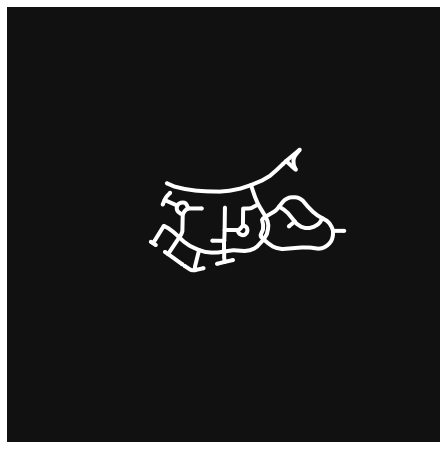

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [92]:
ox.plot.plot_figure_ground(G)

In [94]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

def get_unweighted_bearings(G, threshold):
    # calculate edge bearings
    # threshold lets you discard streets < some length from the bearings analysis
    b = pd.Series([d['bearing'] for u, v, k, d in G.edges(keys=True, data=True) if d['length'] > threshold])
    return pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

def calculate_orientation_entropy(data, n):
    bin_counts = count_and_merge(n, data)
    entropy = stats.entropy(bin_counts)
    return entropy

def orientation_order(eta, max_ent=max_entropy, min_ent=perfect_grid_entropy):
    # normalize it as a value between perfect_grid_entropy and max_entropy
    # then square it to approx linearize orientation_order's relationship with the
    # share of total bins with equal non-zero probabilities
    return 1 - ((eta - min_ent) / (max_ent - min_ent)) ** 2

In [95]:
num_bins = 36
threshold = 10

In [96]:
bearings = get_unweighted_bearings(ox.add_edge_bearings(G), threshold)
orientation_entropy = calculate_orientation_entropy(bearings.dropna(), num_bins)

In [97]:
max_entropy = np.log(num_bins)
max_entropy

3.58351893845611

In [98]:
min_bins = 4
perfect_grid = [1] * min_bins + [0] * (num_bins - min_bins)
perfect_grid_entropy = stats.entropy(perfect_grid)
perfect_grid_entropy

1.3862943611198906

In [150]:
results = {}
error = np.empty(0)

for i in np.arange(0, len(graphs)):
    G = graphs[i]
    
    bearings = get_unweighted_bearings(ox.add_edge_bearings(G), threshold)
    orientation_entropy = calculate_orientation_entropy(bearings.dropna(), num_bins)
    
    net_stats = ox.stats.basic_stats(G)
    
    order = orientation_order(orientation_entropy)
    
    try: 
        inter = net_stats['streets_per_node_proportion'][4]
    except:
        inter = 0
        error = np.append(error, i)
        
    lined = 1 / net_stats['circuity_avg']
    
    results[i] = {'index': i, 
                  'orientation_order': order,
                  'prop_4way': inter,
                  'straightness': lined,
                  'grid_index': stats.gmean([order, inter, lined])}

In [152]:
len(error)

27

In [153]:
results = pd.DataFrame(results).T

In [154]:
montgomery['grid_index'] = results['grid_index']

<AxesSubplot:>

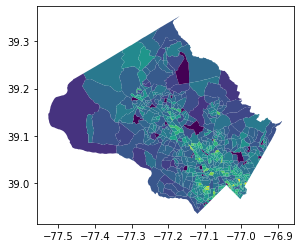

In [155]:
montgomery.plot('grid_index')

In [18]:
state = 24
year = 2015

url = f"https://www2.census.gov/geo/tiger/GENZ{year}/shp/cb_{year}_{state}_bg_500k.zip"

<AxesSubplot:>

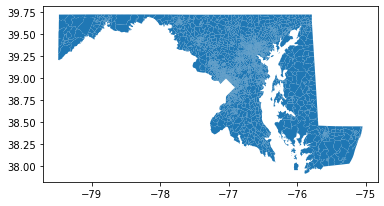

In [71]:
maryland = gpd.read_file(url)
maryland.geometry.plot()

In [166]:
%%time

misses = np.empty(0)
errors = np.empty(0)

results = {}

for i in maryland.index:
    
    geoid = maryland['GEOID'][i]
    
    try: 
        G = ox.graph.graph_from_polygon(polygon=maryland.geometry[i],
                                        network_type='drive')  
    except: 
        misses = np.append(misses, geoid)
        pass
    
    bearings = get_unweighted_bearings(ox.add_edge_bearings(G), threshold)
    orientation_entropy = calculate_orientation_entropy(bearings.dropna(), num_bins)
    
    net_stats = ox.stats.basic_stats(G)
    
    order = orientation_order(orientation_entropy)
    
    try: 
        inter = net_stats['streets_per_node_proportion'][4]
    except:
        inter = 0
        errors = np.append(errors, geoid)
        
    lined = 1 / net_stats['circuity_avg']
    
    results[geoid] = {'orientation_order': order,
                      'prop_4way': inter,
                      'straightness': lined,
                      'grid_index': stats.gmean([order, inter, lined])}
    
results = pd.DataFrame(results).T

/Users/andrewrenninger/anaconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/scipy/stats/stats.py:402: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))
/Users/andrewrenninger/anaconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/Users/andrewrenninger/anaconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/osmnx/stats.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  circuity_avg = edge_length_total / gc_distances.sum()


CPU times: user 33min 20s, sys: 31.2 s, total: 33min 51s
Wall time: 3h 49min


In [178]:
right = results.reset_index()
left = maryland.merge(right, how='left', left_on='GEOID', right_on='index').drop(['index'], axis=1)

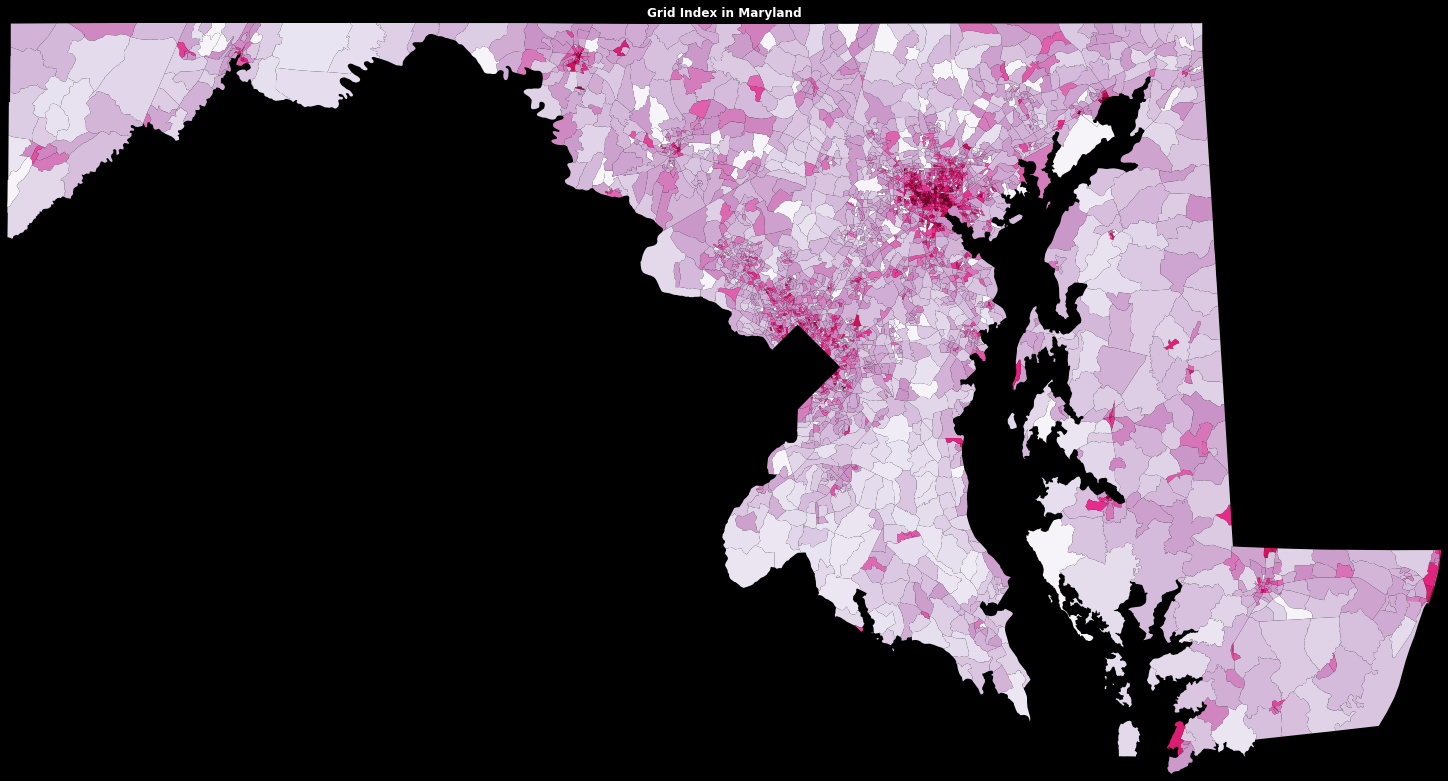

In [192]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

left.plot('grid_index', ax=ax, cmap='PuRd', lw=0.05)
    
ax.set_title("Grid Index in Maryland", color='w', weight='bold')

ax.margins(0)
ax.axis('off')
    
fig.savefig('grid-index_MD.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [188]:
left[['GEOID', 'straightness', 'orientation_order', 'prop_4way', 'grid_index']].to_csv("grid-index_MD.csv")